# **Nombre:** Yeison Fernando Villamil Franco - A01793803

## **Profesor:** Maria de la Paz Rico Fernandez
## **Materia:** Ciencia y Analítica de datos

# **KMeans**

A continuación y continuando con el ejercicio de clustering, se agrega el código para la solución a las preguntas establecidas para este notebook

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
# ! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [5]:
df.head()

,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [7]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

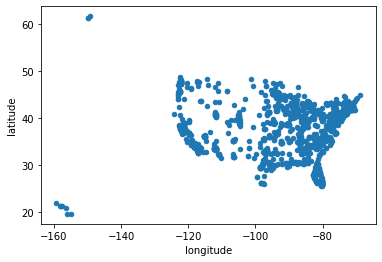

In [8]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [9]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [11]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [12]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [13]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,889953.0,Oceania,Fiji,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,58005463.0,Africa,Tanzania,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,37589262.0,North America,Canada,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,328239523.0,North America,United States of America,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [14]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

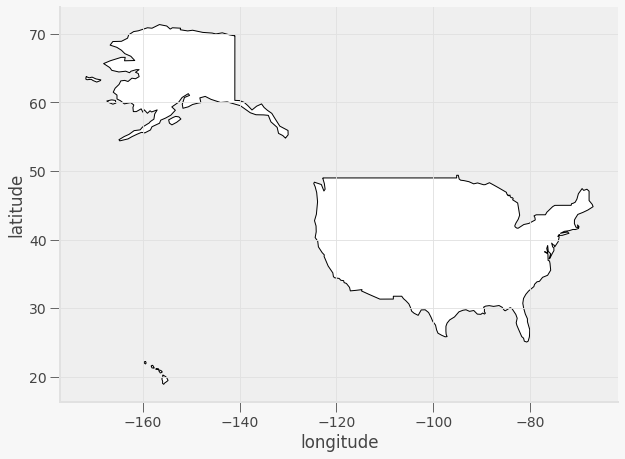

In [15]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

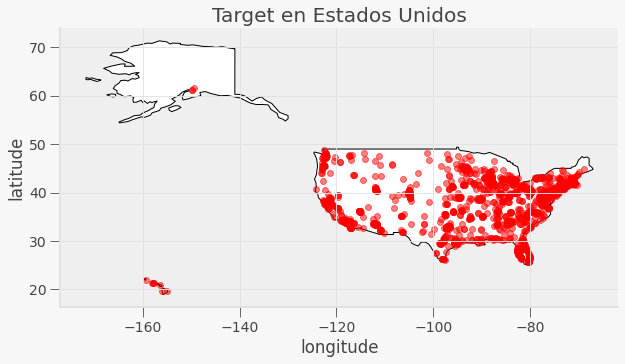

In [16]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

### **1. Encuentra el numero ideal de almacenes, justifica tu respuesta:**

#### Encuentra las latitudes y longitudes de los almacenes, ¿que ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estara?

In [107]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import geopandas
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score
from geopy.geocoders import Nominatim
import geopy.distance

In [21]:
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


#### Clustering para seleccionar el número de tiendas

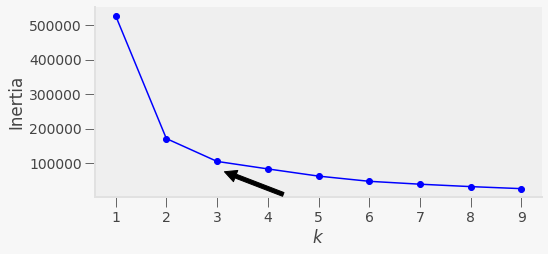

In [38]:
X_cluster = gdf[['latitude', 'longitude']]

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_cluster)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(3, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.grid()
plt.show()

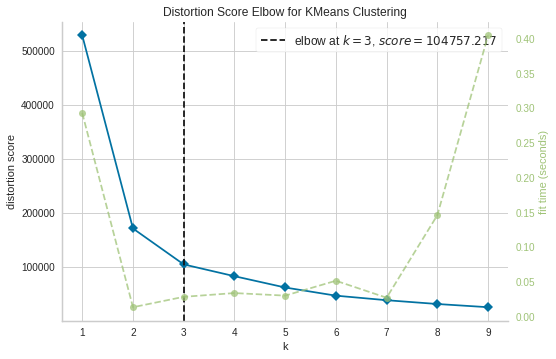

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
vzr = KElbowVisualizer(KMeans(n_clusters=3, random_state=42), k=(1, 10))
vzr.fit(X_cluster)
vzr.poof()

Se observa que en el caso de querer segmentar, tenemos que la mejor decisión sería tener 3 almacenes principales. Esto debido a que el gráfico del `codo` nos muestra que la pendiente disminuye en un punto de 3 cluster. Para terminar de verificar esta suposición, mostraremos el comportamiento de con el score de `silueta`

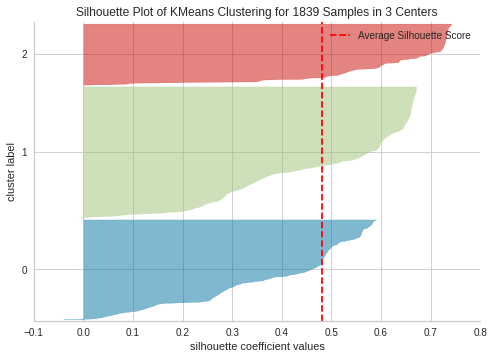

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1839 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [50]:
visualizer = SilhouetteVisualizer(KMeans(n_clusters=3, random_state=42), colors='yellowbrick')
visualizer.fit(X_cluster)        
visualizer.show()        

Esto nos muestra que para el gráfico de silueta, tenemos un valor mayor para 3 cluster

In [52]:
X_cluster = gdf[['latitude', 'longitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_cluster)
y_kmeans = kmeans.predict(X_cluster)

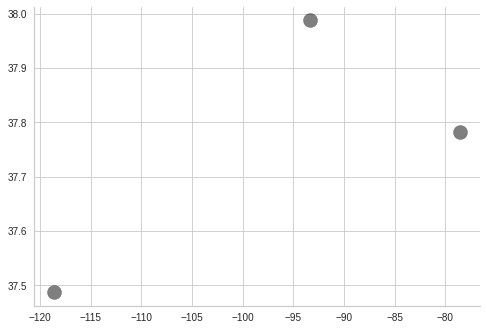

In [55]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

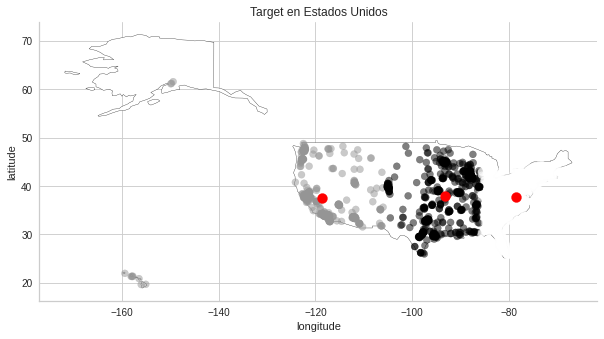

In [80]:
fig, gax = plt.subplots(figsize=(10,10))
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')
gdf.plot(ax=gax, c=y_kmeans, alpha = 0.5)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=100)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Buscamos las coordenadas de los centroides encontrados y en función de esto encontramos las `ciudades` en las cuales pueden ubicarse cada uno de los almacenes

### Estado o ciudad donde se encuentra

In [88]:
df_shops = pd.DataFrame(centers, columns=['Latitude', 'Longitude'])

In [92]:
geolocator = Nominatim(user_agent="geoapiExercises")
def city_state_country(row):
    coord = f"{row['Latitude']}, {row['Longitude']}"
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country', '')
    row['city'] = city
    row['state'] = state
    row['country'] = country
    return row

df = df_shops.apply(city_state_country, axis=1)
df.head() 

,Latitude,Longitude,city,state,country
0,37.783176,-78.552151,,Virginia,United States
1,37.487342,-118.624473,,California,United States
2,37.987822,-93.303540,,Missouri,United States


Con esto tenemos que las ciudades (para este caso se muestran los `estados` ya que pueden ser coordenadas tan específicas que no se encuentran un punto intermedio para estas) a las cuales se ubican los almacenes son:
    
* **CLUSTER 1** : Virginia - United States
* **CLUSTER 2** : California - United States
* **CLUSTER 3** : Missouri - United States

### Cantidad de tiendas a surtir

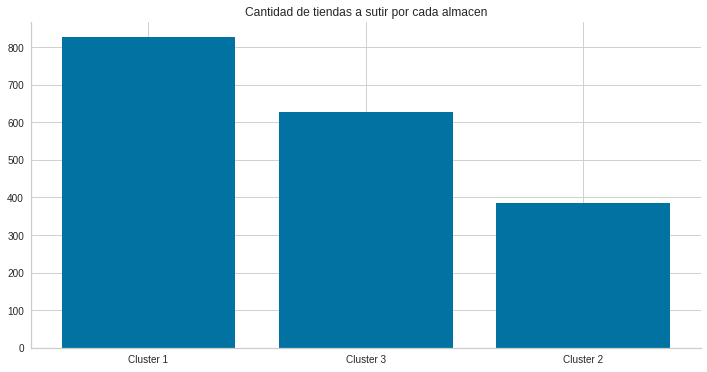

In [100]:
fig, axs = plt.subplots(figsize=(12, 6))
list_names = ['Cluster 1', 'Cluster 3', 'Cluster 2']
list_values = pd.DataFrame(y_kmeans).value_counts().to_list()
axs.bar(list_names, list_values)
plt.title('Cantidad de tiendas a sutir por cada almacen')
plt.show()

### Distancia entre ellas

In [109]:
df_shops

,Latitude,Longitude
0,37.783176,-78.552151
1,37.487342,-118.624473
2,37.987822,-93.303540


In [114]:
cluster_1 = (df_shops.loc[0,:].values)
cluster_2 = (df_shops.loc[1,:].values)
cluster_3 = (df_shops.loc[2,:].values)

In [119]:
dista_cl1_cl2 = geopy.distance.geodesic(cluster_1, cluster_2)
dista_cl1_cl3 = geopy.distance.geodesic(cluster_1, cluster_3)
dista_cl2_cl3 = geopy.distance.geodesic(cluster_2, cluster_3)
print(f'Distancia entre el cluster 1 y cluster 2: {round(dista_cl1_cl2.km,3)} kms')
print(f'Distancia entre el cluster 1 y cluster 3: {round(dista_cl1_cl3.km,3)} kms')
print(f'Distancia entre el cluster 2 y cluster 3: {round(dista_cl2_cl3.km,3)} kms')

Distancia entre el cluster 1 y cluster 2: 3509.491 kms
Distancia entre el cluster 1 y cluster 3: 1296.503 kms
Distancia entre el cluster 2 y cluster 3: 2225.693 kms


### **2. ¿Cómo elegiste el numero de almacenes?, justifica tu respuesta tecnicamente?**

Al realizar una segmentación por cualquier técnica, es importante considerar la cantidad de grupos que se quieren usar para la optimización. La cantidad de grupos óptima se obtiene por medio de una tećnica conocida como gráfico del codo. Esta curva se obtiene por medio de la `inertia` de la técnica `KMeans`. Se define como la distancia entre cada punto con el centroide y a estos se le calcula su raiz cuadrada.

Para comprobar esta información, por medio de la librería `yellowbrick` se obtiene es gráfico donde de manera automática se indica cual es la cantidad grupos óptimo.

### **3. ¿qué librerías nos pueden ayudar a graficar este tipo de datos?**

* `yellowbrick`: Librería que te permite obtener la cantidad de segmentos óptimos
* `geopy`: Permite obtener las ciudades, los estados y las distancias entre puntos `latitude` y `longitude`
* `geopandas`: Por medio de coordenadas te permite tener una orientación geoespacial para entender datos cuando se trata de este tipo de variables

### **4. ¿Consideras importante que se grafique en un mapa?, ¿por qué?**

Cuando se trata de coordenadas `latitude` y `longitude` claramente se hace importante graficar todas las observaciones en un mapa. Esto permitirá entender la distribución geoespacial en el caso de ser necesario y poder generar mayor conocimiento a la hora de tener problemas que consten con este tipo de datos

### **5. Agrega las conclusiones**

* Los métodos de segmentación permiten poder tener grupos específicos para ciertas observaciones y a partir de estos ver cuales coinciden y cómo pueden ser relacionados
* Existen muchas librerías prácticas que permiten ver las distribuciones geoespaciales y los mejores resultados para técnicas de segmentación.
* Se evidencia que si nos enfocamos en `latitude`y `longitude` podemos ubicar tres almacenes grandes que puedan distribución a ciertas tiendas para reducir costos de trasnporte
* El almacen 1 (cluster_1) tienen más tiendas para distribución. Esto se debe a que para esta zona geográfica se encuentra la mayoría de las tiendas (zona oriente de Estados Unidos) y por eso, más distribución.